MOUNT GOOGLE DRIVE 

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


CREATE API TO DOWNLOAD DATASETS FROM KAGGLE ( change username and key ) 

In [ ]:
import os 
os.environ['KAGGLE_USERNAME'] = 'tunvtrnh'
os.environ['KAGGLE_KEY'] = "a270e418383ff4742d1efb0aa56e75cb"

In [ ]:
!kaggle datasets download -d wobotintelligence/face-mask-detection-dataset

UNZIP AND MOVE DATASET TO YOUR DRIVE 

In [ ]:
mkdir train 

In [ ]:
!unzip face-mask-detection-dataset.zip -d train 

In [ ]:
! mv train /content/drive/MyDrive/dataset/

IMPORT LIB AND LOAD DATA


In [5]:
import pandas as pd
import numpy as np

from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
import cv2
from  cv2.dnn import readNetFromCaffe
import json
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
from keras.models import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
directory = "/content/drive/MyDrive/dataset/train/Medical mask/Medical mask/Medical Mask/annotations"
image_directory = "/content/drive/MyDrive/dataset/train/Medical mask/Medical mask/Medical Mask/images"
df = pd.read_csv("/content/drive/MyDrive/dataset/train/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/dataset/train/submission.csv")



LOAD CAFFE MODEL AND CREATE FUNCTIONS

In [50]:
path_weights = "/content/drive/MyDrive/dataset/train/res10_300x300_ssd_iter_140000.caffemodel"
path_pose  = "/content/drive/MyDrive/dataset/train/deploy.prototxt"
cvNet = cv2.dnn.readNetFromCaffe(path_pose,path_weights)
def getJSON(filePathandName):
    with open(filePathandName,'r') as f:
        return json.load(f)
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))


DATA PROCESSING

In [7]:
jsonfiles= []
for i in os.listdir(directory):
    jsonfiles.append(getJSON(os.path.join(directory,i)))
jsonfiles[0]

{'Annotations': [{'Attributes': {},
   'BoundingBox': [247, 131, 546, 510],
   'Confidence': 1,
   'ID': 580488908248698752,
   'classname': 'face_no_mask',
   'isProtected': False}],
 'FileName': '5838.jpg',
 'NumOfAnno': 1}

In [8]:
df = pd.read_csv("/content/drive/MyDrive/dataset/train/train.csv")
df.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


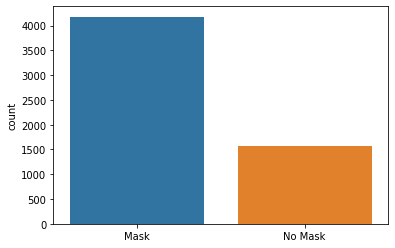

In [9]:
data = []
img_size = 124
mask = ['face_with_mask']
non_mask = ["face_no_mask"]
labels={'mask':0,'without mask':1}
for i in df["name"].unique():
    f = i+".json"
    for j in getJSON(os.path.join(directory,f)).get("Annotations"):
        if j["classname"] in mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))
            data.append([img,labels["mask"]])
        if j["classname"] in non_mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))    
            data.append([img,labels["without mask"]])
random.shuffle(data)

p = []
for face in data:
    if(face[1] == 0):
        p.append("Mask")
    else:
        p.append("No Mask")
sns.countplot(p)

In [10]:
X = []
Y = []
for features,label in data:
    X.append(features)
    Y.append(label)

X = np.array(X)/255.0
X = X.reshape(-1,124,124,3)
Y = np.array(Y)

CREATE MODEL 

In [12]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(124,124,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam' ,metrics=['accuracy'])
xtrain,xval,ytrain,yval=train_test_split(X, Y,train_size=0.8,random_state=0)
datagen = ImageDataGenerator(featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,    
        rotation_range=15,    
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=False)
datagen.fit(xtrain)

CALLBACKS 

In [16]:
from keras.callbacks import ModelCheckpoint
checkpoint_path = "/content/drive/MyDrive/dataset/training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


TRAIN MODEL

In [17]:
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=32),
                    steps_per_epoch=xtrain.shape[0]//32,
                    epochs=50,
                    verbose=1,
                    validation_data=(xval, yval))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
143/143 [==============================] - 56s 154ms/step - loss: 0.5551 - accuracy: 0.7668 - val_loss: 0.2335 - val_accuracy: 0.9087
Epoch 2/50
143/143 [==============================] - 20s 137ms/step - loss: 0.3059 - accuracy: 0.8752 - val_loss: 0.2104 - val_accuracy: 0.9096
Epoch 3/50
143/143 [==============================] - 19s 135ms/step - loss: 0.2867 - accuracy: 0.8870 - val_loss: 0.2148 - val_accuracy: 0.9200
Epoch 4/50
143/143 [==============================] - 19s 136ms/step - loss: 0.2782 - accuracy: 0.8890 - val_loss: 0.1934 - val_accuracy: 0.9183
Epoch 5/50
143/143 [==============================] - 19s 135ms/step - loss: 0.2655 - accuracy: 0.8917 - val_loss: 0.1887 - val_accuracy: 0.9209
Epoch 6/50
143/143 [==============================] - 20s 137ms/step - loss: 0.2664 - accuracy: 0.9033 - val_loss: 0.1898 - val_accuracy: 0.9296
Epoch 7/50
143/143 [==============================] - 20s 137ms/step - loss: 0.2605 - accuracy: 0.8962 - val_loss: 0.1717 - val_ac

TEST MODEL AND VISUALIZE SOME EXAMPLES

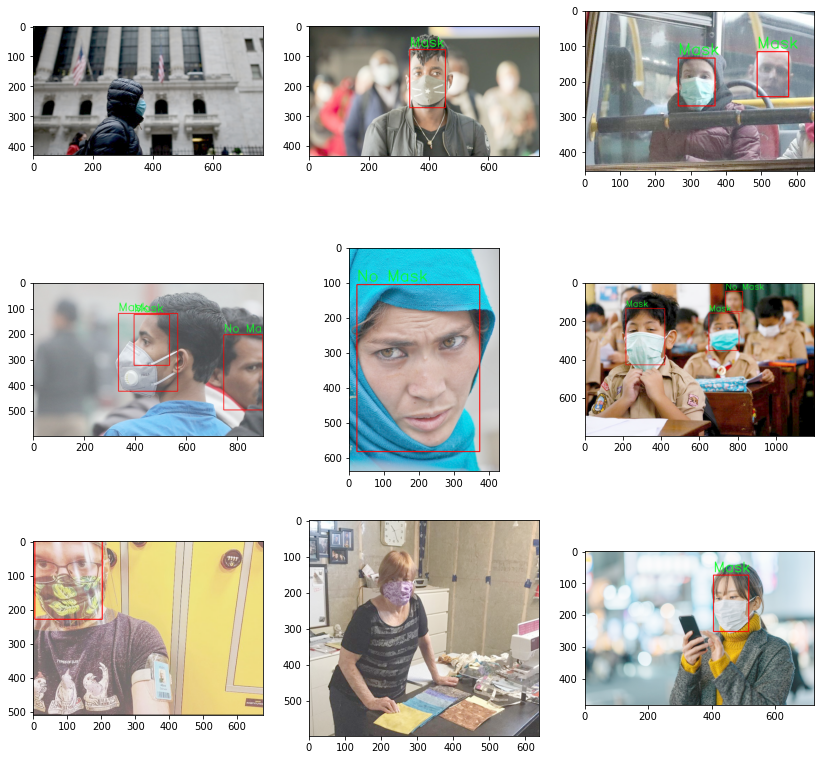

In [56]:
test_images = ['0092.png','1054.jpg', '0411.jpg','0260.jpg','0569.jpg','1373.jpg','0278.png','0501.png','1462.jpg']

gamma = 2.0
fig = plt.figure(figsize = (14,14))
rows = 3
cols = 3
axes = []
assign = {'0':'Mask','1':"No Mask"}
for j,im in enumerate(test_images):
    image =  cv2.imread(os.path.join(image_directory,im),1)
    image =  adjust_gamma(image, gamma=gamma)
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    cvNet.setInput(blob)
    detections = cvNet.forward()
    for i in range(0, detections.shape[2]):
        try:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            frame = image[startY:endY, startX:endX]
            confidence = detections[0, 0, i, 2]
            if confidence > 0.2:
                im = cv2.resize(frame,(img_size,img_size))
                im = np.array(im)/255.0
                im = im.reshape(1,124,124,3)
                result = model.predict(im)
                if result>0.5:
                    label_Y = 1
                else:
                    label_Y = 0
                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
                cv2.putText(image,assign[str(label_Y)] , (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (36,255,12), 2)
        
        except:pass
    axes.append(fig.add_subplot(rows, cols, j+1))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()